<a href="https://colab.research.google.com/github/hurutta/XFedAi/blob/main/XFedAi_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
!pip3 install shap

In [90]:
import pandas as pd
import federated_shap
import numpy as np
import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import sklearn
import shap
shap.initjs()
from sklearn.linear_model import LinearRegression

In [91]:
import io
from google.colab import files
#uploaded = files.upload()
corona_data = pd.read_csv('/content/drive/MyDrive/thesis - all_code/coronavirus_sequences_table.csv')
cov2_data = pd.read_csv('/content/drive/MyDrive/thesis - all_code/sars_cov2_sequences_table.csv')

print(cov2_data.shape)
print(cov2_data.columns)
cov2_data.head()

(559, 17)
Index(['Details', 'Accession', 'Release_Date', 'Species', 'Genus', 'Family',
       'Length', 'Genotype', 'Genome_Region', 'Segment', 'Protein',
       'Geo_Location', 'Host', 'Isolation_Source', 'Collection_Date',
       'BioSample', 'GenBank_Title'],
      dtype='object')


,Details,Accession,Release_Date,Species,Genus,Family,Length,Genotype,Genome_Region,Segment,Protein,Geo_Location,Host,Isolation_Source,Collection_Date,BioSample,GenBank_Title
0,NaN,QHR63260,2020-01-29T00:00:00Z,Severe acute respiratory syndrome-related coro...,Betacoronavirus,Coronaviridae,1273,NaN,NaN,NaN,spike glycoprotein,China,Homo sapiens,lung,2019-12-30,NaN,spike glycoprotein [Severe acute respiratory s...
1,NaN,QHR63265,2020-01-29T00:00:00Z,Severe acute respiratory syndrome-related coro...,Betacoronavirus,Coronaviridae,121,NaN,NaN,NaN,nonstructural protein NS7a,China,Homo sapiens,lung,2019-12-30,NaN,nonstructural protein NS7a [Severe acute respi...
2,NaN,QHR63267,2020-01-29T00:00:00Z,Severe acute respiratory syndrome-related coro...,Betacoronavirus,Coronaviridae,121,NaN,NaN,NaN,nonstructural protein NS8,China,Homo sapiens,lung,2019-12-30,NaN,nonstructural protein NS8 [Severe acute respir...
3,NaN,QHR63261,2020-01-29T00:00:00Z,Severe acute respiratory syndrome-related coro...,Betacoronavirus,Coronaviridae,275,NaN,NaN,NaN,nonstructural protein NS3,China,Homo sapiens,lung,2019-12-30,NaN,nonstructural protein NS3 [Severe acute respir...
4,NaN,QHR63264,2020-01-29T00:00:00Z,Severe acute respiratory syndrome-related coro...,Betacoronavirus,Coronaviridae,61,NaN,NaN,NaN,nonstructural protein NS6,China,Homo sapiens,lung,2019-12-30,NaN,nonstructural protein NS6 [Severe acute respir...


In [92]:
cov2_data.isnull().sum()

Details             559
Accession             0
Release_Date          0
Species               0
Genus                 0
Family                0
Length                0
Genotype            559
Genome_Region       559
Segment             559
Protein               0
Geo_Location          0
Host                  0
Isolation_Source    166
Collection_Date       0
BioSample           559
GenBank_Title         0
dtype: int64

In [93]:
cov2_data=cov2_data.drop(['Details','Genotype','Genome_Region','Segment','BioSample','Species','Family','Host','Accession','Genus','Release_Date'],axis=1)

In [94]:
cov2_data.shape

(559, 6)

In [95]:
#cov2_data=cov2_data.dropna(subset=['Details', 'Accession', 'Release_Date', 'Species', 'Genus', 'Family',
#       'Length', 'Genotype', 'Genome_Region', 'Segment', 'Protein',
#       'Geo_Location', 'Host', 'Isolation_Source', 'Collection_Date',
#       'BioSample', 'GenBank_Title'],axis=0) 

In [96]:
print(cov2_data.shape)
cov2_data

(559, 6)


,Length,Protein,Geo_Location,Isolation_Source,Collection_Date,GenBank_Title
0,1273,spike glycoprotein,China,lung,2019-12-30,spike glycoprotein [Severe acute respiratory s...
1,121,nonstructural protein NS7a,China,lung,2019-12-30,nonstructural protein NS7a [Severe acute respi...
2,121,nonstructural protein NS8,China,lung,2019-12-30,nonstructural protein NS8 [Severe acute respir...
3,275,nonstructural protein NS3,China,lung,2019-12-30,nonstructural protein NS3 [Severe acute respir...
4,61,nonstructural protein NS6,China,lung,2019-12-30,nonstructural protein NS6 [Severe acute respir...
...,...,...,...,...,...,...
554,61,ORF6 protein,China,oronasopharynx,2020-02-05,ORF6 protein [Severe acute respiratory syndrom...
555,121,ORF7a protein,China,oronasopharynx,2020-02-05,ORF7a protein [Severe acute respiratory syndro...
556,121,ORF8 protein,China,oronasopharynx,2020-02-05,ORF8 protein [Severe acute respiratory syndrom...
557,419,nucleocapsid phosphoprotein,China,oronasopharynx,2020-02-05,nucleocapsid phosphoprotein [Severe acute resp...


In [97]:
cov2_data['Protein'].unique().size

49

In [98]:
cov2_data2=cov2_data['GenBank_Title']
print(cov2_data2.size)
for i in range(0,cov2_data2.size,1):
    a,b = cov2_data2[i].split("[") 
    b=b[:-1]
    cov2_data2[i]=b

cov2_data2

559



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0      Severe acute respiratory syndrome coronavirus 2
1      Severe acute respiratory syndrome coronavirus 2
2      Severe acute respiratory syndrome coronavirus 2
3      Severe acute respiratory syndrome coronavirus 2
4      Severe acute respiratory syndrome coronavirus 2
                            ...                       
554    Severe acute respiratory syndrome coronavirus 2
555    Severe acute respiratory syndrome coronavirus 2
556    Severe acute respiratory syndrome coronavirus 2
557    Severe acute respiratory syndrome coronavirus 2
558    Severe acute respiratory syndrome coronavirus 2
Name: GenBank_Title, Length: 559, dtype: object

In [99]:
cov2_data['GenBank_Title']=cov2_data2

In [100]:
print(cov2_data.columns)
cov2_data.head()

Index(['Length', 'Protein', 'Geo_Location', 'Isolation_Source',
       'Collection_Date', 'GenBank_Title'],
      dtype='object')


,Length,Protein,Geo_Location,Isolation_Source,Collection_Date,GenBank_Title
0,1273,spike glycoprotein,China,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2
1,121,nonstructural protein NS7a,China,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2
2,121,nonstructural protein NS8,China,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2
3,275,nonstructural protein NS3,China,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2
4,61,nonstructural protein NS6,China,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2


In [101]:
########### dataset description at a glance ############
for col in cov2_data:
    print(col,cov2_data[col].unique().size,cov2_data[col].unique(),'\n\n')
cov2_data.describe()
########################################################

Length 42 [1273  121  275   61  222  419 7096   75   38 7095   60   95   35   96
   43  107 4405  269  223  119  187   98 7088  306 1945  139   13  601
  298  932  290  346  113   83  500  527  198  638  110   70  256  180] 


Protein 49 ['spike glycoprotein' 'nonstructural protein NS7a'
 'nonstructural protein NS8' 'nonstructural protein NS3'
 'nonstructural protein NS6' 'membrane glycoprotein'
 'nucleocapsid phosphoprotein' 'orf1ab polyprotein' 'orf7a protein'
 'envelope protein' 'surface glycoprotein' 'orf3a protein' 'ORF8 protein'
 'orf8 protein' 'orf10 protein' 'orf6 protein' 'ORF7a protein'
 'structural protein' 'ORF10 proteiin' 'ORF3a protein' 'ORF6 protein'
 'ORF10 protein' 'ORF1ab polyprotein' 'nucleocapsid protein'
 'nonstructural protein NS7b' 'membrane protein' 'matrix protein'
 'orf1a polyprotein' 'ORF7b protein' 'ORF7b' 'ORF7 protein' 'ORF3 protein'
 '3C-like proteinase' 'nsp3' 'nsp10' 'nsp11' 'helicase'
 "2'-O-ribose methyltransferase" 'RNA-dependent RNA polymerase' 'nsp

,Length
count,559.000000
mean,916.885510
std,1991.206788
min,13.000000
25%,75.000000
50%,180.000000
75%,419.000000
max,7096.000000


In [102]:
#cov2_data2=cov2_data['Collection_Date']
#df["column3"] = ""
#print(cov2_data2)
cov2_data.insert(0,'Collection_Day','')
cov2_data.insert(0,'Collection_Month','')
cov2_data.insert(0,'Collection_Year','')



In [103]:
cov2_data

,Collection_Year,Collection_Month,Collection_Day,Length,Protein,Geo_Location,Isolation_Source,Collection_Date,GenBank_Title
0,,,,1273,spike glycoprotein,China,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2
1,,,,121,nonstructural protein NS7a,China,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2
2,,,,121,nonstructural protein NS8,China,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2
3,,,,275,nonstructural protein NS3,China,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2
4,,,,61,nonstructural protein NS6,China,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2
...,...,...,...,...,...,...,...,...,...
554,,,,61,ORF6 protein,China,oronasopharynx,2020-02-05,Severe acute respiratory syndrome coronavirus 2
555,,,,121,ORF7a protein,China,oronasopharynx,2020-02-05,Severe acute respiratory syndrome coronavirus 2
556,,,,121,ORF8 protein,China,oronasopharynx,2020-02-05,Severe acute respiratory syndrome coronavirus 2
557,,,,419,nucleocapsid phosphoprotein,China,oronasopharynx,2020-02-05,Severe acute respiratory syndrome coronavirus 2


In [104]:
cov2_data.columns
cov2_data.shape

cov2_data2=cov2_data['Collection_Date']
for i in range(0,cov2_data2.size,1):
    try:
        a,b,c = cov2_data2[i].split("-")
        cov2_data['Collection_Year'][i]=int(a)
        cov2_data['Collection_Month'][i]=int(b)
        cov2_data['Collection_Day'][i]=int(c)
    except:
        a,b = cov2_data2[i].split("-")
        cov2_data['Collection_Year'][i]=int(a)
        cov2_data['Collection_Month'][i]=int(b)
        cov2_data['Collection_Day'][i]=np.NaN
    


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [105]:
cov2_data['Collection_Day'].unique()
cov2_data['Collection_Month'].unique()
cov2_data['GenBank_Title'].unique()
print(cov2_data['GenBank_Title'])
print(cov2_data['GenBank_Title'].unique())

0      Severe acute respiratory syndrome coronavirus 2
1      Severe acute respiratory syndrome coronavirus 2
2      Severe acute respiratory syndrome coronavirus 2
3      Severe acute respiratory syndrome coronavirus 2
4      Severe acute respiratory syndrome coronavirus 2
                            ...                       
554    Severe acute respiratory syndrome coronavirus 2
555    Severe acute respiratory syndrome coronavirus 2
556    Severe acute respiratory syndrome coronavirus 2
557    Severe acute respiratory syndrome coronavirus 2
558    Severe acute respiratory syndrome coronavirus 2
Name: GenBank_Title, Length: 559, dtype: object
['Severe acute respiratory syndrome coronavirus 2'
 'Wuhan seafood market pneumonia virus']


In [106]:
set1={""}
set2={""}
set3={""}
for i in range(0,cov2_data['GenBank_Title'].size,1):
    if cov2_data['GenBank_Title'][i] == "Severe acute respiratory syndrome coronavirus 2":
        set1.add(cov2_data['Protein'][i])
        set3.add(cov2_data['Protein'][i])
    else:
        set2.add(cov2_data['Protein'][i])
        set3.add(cov2_data['Protein'][i])

set4 = set1 & set2 
set5 = set1 - set2 
print("matched : ",len(set4)," miss_matched : ",len(set5))

matched :  13  miss_matched :  21


In [107]:
#cov2_data['Isolation_Source'].unique()
cov2_data.isnull().sum()

Collection_Year       0
Collection_Month      0
Collection_Day      115
Length                0
Protein               0
Geo_Location          0
Isolation_Source    166
Collection_Date       0
GenBank_Title         0
dtype: int64

In [108]:
from sklearn.impute import SimpleImputer

impute = SimpleImputer(missing_values=np.nan,strategy='mean')
impute.fit(cov2_data[['Collection_Day']])
cov2_data['Collection_Day']=impute.transform(cov2_data[['Collection_Day']])

In [109]:
cov2_data.isnull().sum()

Collection_Year       0
Collection_Month      0
Collection_Day        0
Length                0
Protein               0
Geo_Location          0
Isolation_Source    166
Collection_Date       0
GenBank_Title         0
dtype: int64

# =====================================================================

---



In [110]:
prt=cov2_data['Protein']
cov2_data['Protein'].unique().size

49

In [111]:
from sklearn.feature_extraction import FeatureHasher
fh = FeatureHasher(n_features=4, input_type='string')
hashed_features = fh.fit_transform(cov2_data['Protein'])
hashed_features = hashed_features.toarray()
for i in range(0,30,1):
    print(cov2_data['Protein'][i],"\t",hashed_features[i])
#pd.concat([vg_df[['Name', 'Genre']], pd.DataFrame(hashed_features)], axis=1).iloc[1:7]
cov2_data.shape
#cov2_data.insert(0,'Collection_Day','')
cov2_data=pd.concat([cov2_data, pd.DataFrame(hashed_features)], axis=1)
print(cov2_data.shape)
print(cov2_data.head())
cov2_data=cov2_data.drop(['Protein'],axis=1)
print(cov2_data.shape)

spike glycoprotein 	 [ 1. -2. -2.  1.]
nonstructural protein NS7a 	 [ 2.  1.  1. -2.]
nonstructural protein NS8 	 [ 1.  0.  0. -2.]
nonstructural protein NS3 	 [ 2.  1.  0. -2.]
nonstructural protein NS6 	 [ 2.  1.  0. -2.]
membrane glycoprotein 	 [ 2. -1.  0.  4.]
nucleocapsid phosphoprotein 	 [ 1. -5. -3.  4.]
orf1ab polyprotein 	 [ 1. -1.  0.  4.]
orf7a protein 	 [1. 1. 0. 3.]
envelope protein 	 [ 0.  0. -2.  4.]
surface glycoprotein 	 [ 2. -1.  0.  3.]
orf3a protein 	 [1. 1. 0. 3.]
ORF8 protein 	 [ 0.  0. -1.  1.]
orf8 protein 	 [ 0.  0. -1.  3.]
membrane glycoprotein 	 [ 2. -1.  0.  4.]
envelope protein 	 [ 0.  0. -2.  4.]
orf1ab polyprotein 	 [ 1. -1.  0.  4.]
nucleocapsid phosphoprotein 	 [ 1. -5. -3.  4.]
orf10 protein 	 [ 0. -1. -1.  3.]
orf6 protein 	 [ 1.  1. -1.  3.]
orf7a protein 	 [1. 1. 0. 3.]
surface glycoprotein 	 [ 2. -1.  0.  3.]
orf3a protein 	 [1. 1. 0. 3.]
nucleocapsid phosphoprotein 	 [ 1. -5. -3.  4.]
orf3a protein 	 [1. 1. 0. 3.]
orf10 protein 	 [ 0. -1. -1.  3

In [112]:
cov2_data

,Collection_Year,Collection_Month,Collection_Day,Length,Geo_Location,Isolation_Source,Collection_Date,GenBank_Title,0,1,2,3
0,2019,12,30.0,1273,China,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2,1.0,-2.0,-2.0,1.0
1,2019,12,30.0,121,China,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2,2.0,1.0,1.0,-2.0
2,2019,12,30.0,121,China,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2,1.0,0.0,0.0,-2.0
3,2019,12,30.0,275,China,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2,2.0,1.0,0.0,-2.0
4,2019,12,30.0,61,China,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2,2.0,1.0,0.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
554,2020,2,5.0,61,China,oronasopharynx,2020-02-05,Severe acute respiratory syndrome coronavirus 2,1.0,1.0,-1.0,1.0
555,2020,2,5.0,121,China,oronasopharynx,2020-02-05,Severe acute respiratory syndrome coronavirus 2,1.0,1.0,0.0,1.0
556,2020,2,5.0,121,China,oronasopharynx,2020-02-05,Severe acute respiratory syndrome coronavirus 2,0.0,0.0,-1.0,1.0
557,2020,2,5.0,419,China,oronasopharynx,2020-02-05,Severe acute respiratory syndrome coronavirus 2,1.0,-5.0,-3.0,4.0


In [113]:
cov2_data=cov2_data.rename(columns={0: 'protein_hash1',1:'protein_hash2',2: 'protein_hash3',3: 'protein_hash4'})    #  - hashed for protein name

In [114]:
cov2_data

,Collection_Year,Collection_Month,Collection_Day,Length,Geo_Location,Isolation_Source,Collection_Date,GenBank_Title,protein_hash1,protein_hash2,protein_hash3,protein_hash4
0,2019,12,30.0,1273,China,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2,1.0,-2.0,-2.0,1.0
1,2019,12,30.0,121,China,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2,2.0,1.0,1.0,-2.0
2,2019,12,30.0,121,China,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2,1.0,0.0,0.0,-2.0
3,2019,12,30.0,275,China,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2,2.0,1.0,0.0,-2.0
4,2019,12,30.0,61,China,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2,2.0,1.0,0.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
554,2020,2,5.0,61,China,oronasopharynx,2020-02-05,Severe acute respiratory syndrome coronavirus 2,1.0,1.0,-1.0,1.0
555,2020,2,5.0,121,China,oronasopharynx,2020-02-05,Severe acute respiratory syndrome coronavirus 2,1.0,1.0,0.0,1.0
556,2020,2,5.0,121,China,oronasopharynx,2020-02-05,Severe acute respiratory syndrome coronavirus 2,0.0,0.0,-1.0,1.0
557,2020,2,5.0,419,China,oronasopharynx,2020-02-05,Severe acute respiratory syndrome coronavirus 2,1.0,-5.0,-3.0,4.0


In [115]:
cov2_data['Geo_Location'].unique().size

14

In [116]:
from sklearn.feature_extraction import FeatureHasher
fh = FeatureHasher(n_features=2, input_type='string')
hashed_features = fh.fit_transform(cov2_data['Geo_Location'])
hashed_features = hashed_features.toarray()
for i in range(30,60,1):
    print(cov2_data['Geo_Location'][i],"\t",hashed_features[i])
#pd.concat([vg_df[['Name', 'Genre']], pd.DataFrame(hashed_features)], axis=1).iloc[1:7]
cov2_data.shape
#cov2_data.insert(0,'Collection_Day','')


USA 	 [-1.  0.]
USA 	 [-1.  0.]
USA 	 [-1.  0.]
China 	 [ 0. -3.]
China 	 [ 0. -3.]
China 	 [ 0. -3.]
China 	 [ 0. -3.]
China 	 [ 0. -3.]
China 	 [ 0. -3.]
China 	 [ 0. -3.]
China 	 [ 0. -3.]
China 	 [ 0. -3.]
China 	 [ 0. -3.]
South Korea 	 [1. 2.]
South Korea 	 [1. 2.]
South Korea 	 [1. 2.]
South Korea 	 [1. 2.]
South Korea 	 [1. 2.]
South Korea 	 [1. 2.]
South Korea 	 [1. 2.]
South Korea 	 [1. 2.]
South Korea 	 [1. 2.]
South Korea 	 [1. 2.]
USA 	 [-1.  0.]
USA 	 [-1.  0.]
USA 	 [-1.  0.]
USA 	 [-1.  0.]
USA 	 [-1.  0.]
USA 	 [-1.  0.]
USA 	 [-1.  0.]


(559, 12)

In [117]:
cov2_data=pd.concat([cov2_data, pd.DataFrame(hashed_features)], axis=1)
print(cov2_data.shape)
print(cov2_data.head())
cov2_data=cov2_data.drop(['Geo_Location'],axis=1)
print(cov2_data.shape)

(559, 14)
  Collection_Year Collection_Month  Collection_Day  ...  protein_hash4    0    1
0            2019               12            30.0  ...            1.0  0.0 -3.0
1            2019               12            30.0  ...           -2.0  0.0 -3.0
2            2019               12            30.0  ...           -2.0  0.0 -3.0
3            2019               12            30.0  ...           -2.0  0.0 -3.0
4            2019               12            30.0  ...           -2.0  0.0 -3.0

[5 rows x 14 columns]
(559, 13)


In [118]:
cov2_data=cov2_data.rename(columns={0: 'geo_hash1',1:'geo_hash2'})              # E F - geo name
cov2_data

,Collection_Year,Collection_Month,Collection_Day,Length,Isolation_Source,Collection_Date,GenBank_Title,protein_hash1,protein_hash2,protein_hash3,protein_hash4,geo_hash1,geo_hash2
0,2019,12,30.0,1273,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2,1.0,-2.0,-2.0,1.0,0.0,-3.0
1,2019,12,30.0,121,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2,2.0,1.0,1.0,-2.0,0.0,-3.0
2,2019,12,30.0,121,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2,1.0,0.0,0.0,-2.0,0.0,-3.0
3,2019,12,30.0,275,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2,2.0,1.0,0.0,-2.0,0.0,-3.0
4,2019,12,30.0,61,lung,2019-12-30,Severe acute respiratory syndrome coronavirus 2,2.0,1.0,0.0,-2.0,0.0,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,2020,2,5.0,61,oronasopharynx,2020-02-05,Severe acute respiratory syndrome coronavirus 2,1.0,1.0,-1.0,1.0,0.0,-3.0
555,2020,2,5.0,121,oronasopharynx,2020-02-05,Severe acute respiratory syndrome coronavirus 2,1.0,1.0,0.0,1.0,0.0,-3.0
556,2020,2,5.0,121,oronasopharynx,2020-02-05,Severe acute respiratory syndrome coronavirus 2,0.0,0.0,-1.0,1.0,0.0,-3.0
557,2020,2,5.0,419,oronasopharynx,2020-02-05,Severe acute respiratory syndrome coronavirus 2,1.0,-5.0,-3.0,4.0,0.0,-3.0


# =====================================================================

---



In [119]:
cov2_data = pd.get_dummies(cov2_data,columns=['Isolation_Source'])

In [120]:
cov2_data.isnull().sum()

Collection_Year                          0
Collection_Month                         0
Collection_Day                           0
Length                                   0
Collection_Date                          0
GenBank_Title                            0
protein_hash1                            0
protein_hash2                            0
protein_hash3                            0
protein_hash4                            0
geo_hash1                                0
geo_hash2                                0
Isolation_Source_blood                   0
Isolation_Source_feces                   0
Isolation_Source_lung                    0
Isolation_Source_lung, oronasopharynx    0
Isolation_Source_oronasopharynx          0
Isolation_Source_swab                    0
dtype: int64

In [121]:
"""50
0 0 0 0 0 
0 0 0 0 1
0 0 0 1 0
0 0 0 1 1"""

'50\n0 0 0 0 0 \n0 0 0 0 1\n0 0 0 1 0\n0 0 0 1 1'

In [122]:
cov2_data

,Collection_Year,Collection_Month,Collection_Day,Length,Collection_Date,GenBank_Title,protein_hash1,protein_hash2,protein_hash3,protein_hash4,geo_hash1,geo_hash2,Isolation_Source_blood,Isolation_Source_feces,Isolation_Source_lung,"Isolation_Source_lung, oronasopharynx",Isolation_Source_oronasopharynx,Isolation_Source_swab
0,2019,12,30.0,1273,2019-12-30,Severe acute respiratory syndrome coronavirus 2,1.0,-2.0,-2.0,1.0,0.0,-3.0,0,0,1,0,0,0
1,2019,12,30.0,121,2019-12-30,Severe acute respiratory syndrome coronavirus 2,2.0,1.0,1.0,-2.0,0.0,-3.0,0,0,1,0,0,0
2,2019,12,30.0,121,2019-12-30,Severe acute respiratory syndrome coronavirus 2,1.0,0.0,0.0,-2.0,0.0,-3.0,0,0,1,0,0,0
3,2019,12,30.0,275,2019-12-30,Severe acute respiratory syndrome coronavirus 2,2.0,1.0,0.0,-2.0,0.0,-3.0,0,0,1,0,0,0
4,2019,12,30.0,61,2019-12-30,Severe acute respiratory syndrome coronavirus 2,2.0,1.0,0.0,-2.0,0.0,-3.0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,2020,2,5.0,61,2020-02-05,Severe acute respiratory syndrome coronavirus 2,1.0,1.0,-1.0,1.0,0.0,-3.0,0,0,0,0,1,0
555,2020,2,5.0,121,2020-02-05,Severe acute respiratory syndrome coronavirus 2,1.0,1.0,0.0,1.0,0.0,-3.0,0,0,0,0,1,0
556,2020,2,5.0,121,2020-02-05,Severe acute respiratory syndrome coronavirus 2,0.0,0.0,-1.0,1.0,0.0,-3.0,0,0,0,0,1,0
557,2020,2,5.0,419,2020-02-05,Severe acute respiratory syndrome coronavirus 2,1.0,-5.0,-3.0,4.0,0.0,-3.0,0,0,0,0,1,0


In [123]:
cov2_data=cov2_data.drop(['Collection_Date'],axis=1)
cov2_data.shape

(559, 17)

In [124]:
cov2_data['GenBank_Title']=cov2_data['GenBank_Title'].map({'Severe acute respiratory syndrome coronavirus 2': 1, 'Wuhan seafood market pneumonia virus': 0})

In [125]:
cov2_data

,Collection_Year,Collection_Month,Collection_Day,Length,GenBank_Title,protein_hash1,protein_hash2,protein_hash3,protein_hash4,geo_hash1,geo_hash2,Isolation_Source_blood,Isolation_Source_feces,Isolation_Source_lung,"Isolation_Source_lung, oronasopharynx",Isolation_Source_oronasopharynx,Isolation_Source_swab
0,2019,12,30.0,1273,1,1.0,-2.0,-2.0,1.0,0.0,-3.0,0,0,1,0,0,0
1,2019,12,30.0,121,1,2.0,1.0,1.0,-2.0,0.0,-3.0,0,0,1,0,0,0
2,2019,12,30.0,121,1,1.0,0.0,0.0,-2.0,0.0,-3.0,0,0,1,0,0,0
3,2019,12,30.0,275,1,2.0,1.0,0.0,-2.0,0.0,-3.0,0,0,1,0,0,0
4,2019,12,30.0,61,1,2.0,1.0,0.0,-2.0,0.0,-3.0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,2020,2,5.0,61,1,1.0,1.0,-1.0,1.0,0.0,-3.0,0,0,0,0,1,0
555,2020,2,5.0,121,1,1.0,1.0,0.0,1.0,0.0,-3.0,0,0,0,0,1,0
556,2020,2,5.0,121,1,0.0,0.0,-1.0,1.0,0.0,-3.0,0,0,0,0,1,0
557,2020,2,5.0,419,1,1.0,-5.0,-3.0,4.0,0.0,-3.0,0,0,0,0,1,0


In [126]:
#print(cov2_data['GenBank_Title'].unique())
cov2_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Collection_Year                        559 non-null    object 
 1   Collection_Month                       559 non-null    object 
 2   Collection_Day                         559 non-null    float64
 3   Length                                 559 non-null    int64  
 4   GenBank_Title                          559 non-null    int64  
 5   protein_hash1                          559 non-null    float64
 6   protein_hash2                          559 non-null    float64
 7   protein_hash3                          559 non-null    float64
 8   protein_hash4                          559 non-null    float64
 9   geo_hash1                              559 non-null    float64
 10  geo_hash2                              559 non-null    float64
 11  Isolat

                                       Collection_Day  ...  Isolation_Source_swab
Collection_Day                           1.000000e+00  ...          -2.797312e-17
Length                                  -1.507529e-02  ...          -4.287545e-02
GenBank_Title                           -1.711394e-17  ...           2.391910e-02
protein_hash1                            2.563110e-02  ...           5.252884e-03
protein_hash2                            9.300558e-03  ...          -1.974181e-02
protein_hash3                            2.278865e-03  ...           7.407181e-02
protein_hash4                           -5.214585e-02  ...           9.054327e-02
geo_hash1                               -1.300892e-02  ...           9.487160e-03
geo_hash2                                1.956533e-02  ...          -9.787210e-02
Isolation_Source_blood                   2.795582e-18  ...          -4.409567e-03
Isolation_Source_feces                   1.489831e-02  ...          -1.405811e-02
Isolation_Source

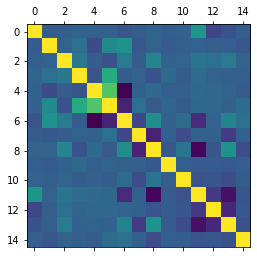

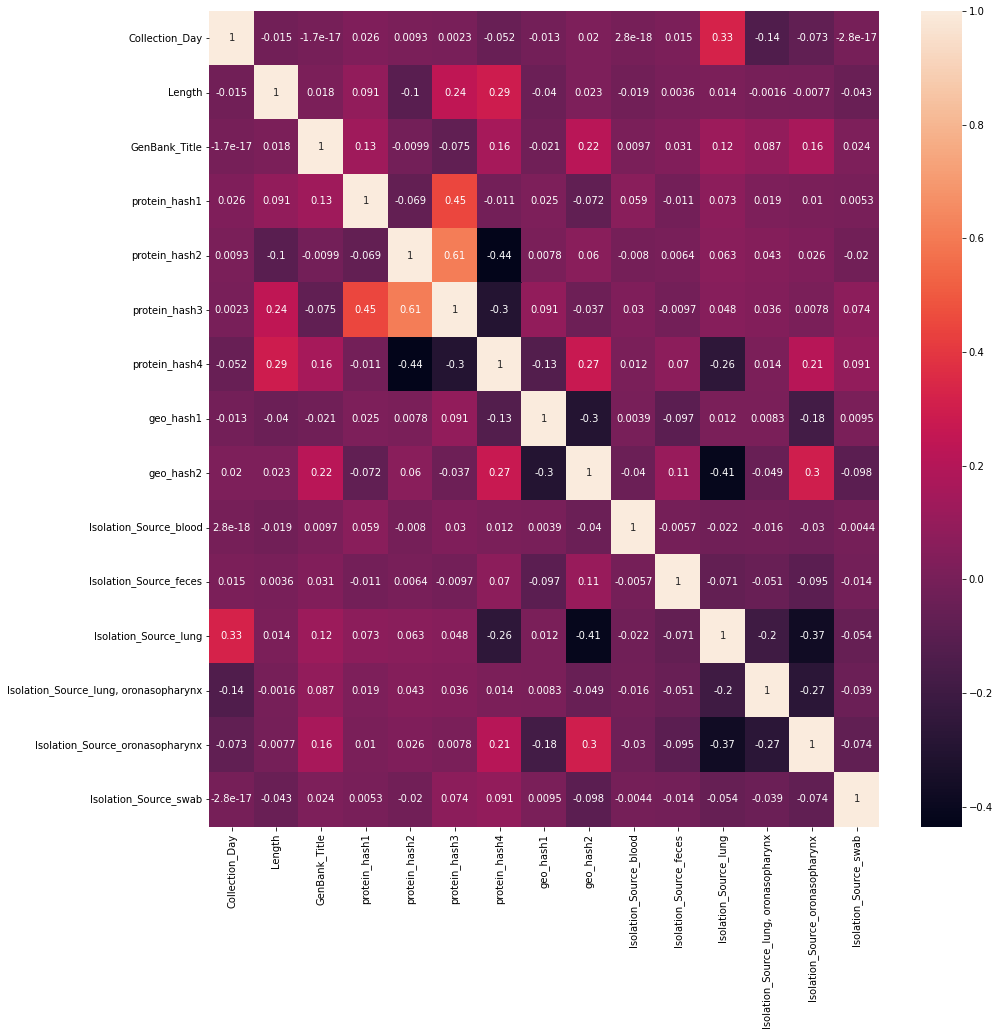

In [127]:
import seaborn as sn
import matplotlib.pyplot as plt
co_re=cov2_data.corr()               #co relation of features
plt.matshow(co_re)

print(co_re)
plt.show()                      #heat map of co relation
plt.figure(figsize = (15,15))
sn.heatmap(co_re,annot=True)   #heat map with more info

In [128]:
cov2_data.columns

Index(['Collection_Year', 'Collection_Month', 'Collection_Day', 'Length',
       'GenBank_Title', 'protein_hash1', 'protein_hash2', 'protein_hash3',
       'protein_hash4', 'geo_hash1', 'geo_hash2', 'Isolation_Source_blood',
       'Isolation_Source_feces', 'Isolation_Source_lung',
       'Isolation_Source_lung, oronasopharynx',
       'Isolation_Source_oronasopharynx', 'Isolation_Source_swab'],
      dtype='object')

In [129]:
cov2_data=cov2_data.drop(['protein_hash1','protein_hash2'],axis=1)
cov2_data.columns

Index(['Collection_Year', 'Collection_Month', 'Collection_Day', 'Length',
       'GenBank_Title', 'protein_hash3', 'protein_hash4', 'geo_hash1',
       'geo_hash2', 'Isolation_Source_blood', 'Isolation_Source_feces',
       'Isolation_Source_lung', 'Isolation_Source_lung, oronasopharynx',
       'Isolation_Source_oronasopharynx', 'Isolation_Source_swab'],
      dtype='object')

In [132]:
for col in cov2_data:
    print(col,cov2_data[col].unique().size,cov2_data[col].unique(),'\n\n')
cov2_data.describe()

Collection_Year 2 [2019 2020] 


Collection_Month 3 [12 1 2] 


Collection_Day 25 [30.         22.          1.         29.         20.         21.07207207
 31.         26.         23.          8.          2.         19.
 11.         25.          3.         24.          6.         13.
 28.         17.          5.         27.         21.         10.
  7.        ] 


Length 42 [1273  121  275   61  222  419 7096   75   38 7095   60   95   35   96
   43  107 4405  269  223  119  187   98 7088  306 1945  139   13  601
  298  932  290  346  113   83  500  527  198  638  110   70  256  180] 


GenBank_Title 2 [1 0] 


protein_hash3 7 [-2.  1.  0. -3. -1.  3.  2.] 


protein_hash4 7 [ 1. -2.  4.  3.  2.  0. -1.] 


geo_hash1 8 [ 0. -1.  1. -2.  2.  4.  5.  6.] 


geo_hash2 7 [-3.  0.  2. -5. -2. -1.  1.] 


Isolation_Source_blood 2 [0 1] 


Isolation_Source_feces 2 [0 1] 


Isolation_Source_lung 2 [1 0] 


Isolation_Source_lung, oronasopharynx 2 [0 1] 


Isolation_Source_oronasopharynx 2 [0 1]

,Collection_Day,Length,GenBank_Title,protein_hash3,protein_hash4,geo_hash1,geo_hash2,Isolation_Source_blood,Isolation_Source_feces,Isolation_Source_lung,"Isolation_Source_lung, oronasopharynx",Isolation_Source_oronasopharynx,Isolation_Source_swab
count,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000
mean,21.072072,916.885510,0.949911,-0.726297,2.524150,-0.112701,-1.407871,0.001789,0.017889,0.214669,0.125224,0.332737,0.010733
std,8.413559,1991.206788,0.218325,1.022264,1.699369,1.238495,1.695982,0.042295,0.132667,0.410960,0.331269,0.471615,0.103137
min,1.000000,13.000000,0.000000,-3.000000,-2.000000,-2.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,75.000000,1.000000,-1.000000,1.000000,-1.000000,-3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,21.072072,180.000000,1.000000,0.000000,3.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,29.000000,419.000000,1.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,31.000000,7096.000000,1.000000,3.000000,4.000000,6.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000




---


# `data processing done, further work starts here`

---



In [217]:
from sklearn.model_selection import train_test_split
#print(data.columns

lebel=['GenBank_Title']
features=[]
X=cov2_data[['geo_hash1', 'geo_hash2', 'Length', 'Isolation_Source_blood',
    'Isolation_Source_feces', 'Isolation_Source_lung', 'Isolation_Source_lung, oronasopharynx',
    'Isolation_Source_oronasopharynx', 'Isolation_Source_swab', 'protein_hash3', 'protein_hash4']]
       
y=cov2_data[lebel]      

#X=X.drop(['GenBank_Title'],axis=1)
print(X.columns)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=4)  #splitting train-test 70%-30%
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

Index(['geo_hash1', 'geo_hash2', 'Length', 'Isolation_Source_blood',
       'Isolation_Source_feces', 'Isolation_Source_lung',
       'Isolation_Source_lung, oronasopharynx',
       'Isolation_Source_oronasopharynx', 'Isolation_Source_swab',
       'protein_hash3', 'protein_hash4'],
      dtype='object')
(391, 11) (391, 1) (168, 11) (168, 1)


In [218]:
y_train=y_train.values.ravel()
y_test=y_test.values.ravel()

In [219]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=3)  #hyper para needed -         , k fold
knn.fit(X_train,y_train)
acr=knn.score(X_test, y_test)*100
print("Accuracy : {:.2f}".format(acr),"%")


Accuracy : 96.43 %


In [220]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
svm=SVC(kernel='linear')    #SVC(kernel='linear') gamma='auto'
svm.fit(X_train,y_train)
acr2=svm.score(X_test,y_test)*100
print("Accuracy : {:.2f}".format(acr2),"%")

Accuracy : 95.24 %


In [221]:

#train model
knn_norm = sklearn.neighbors.KNeighborsClassifier()
knn_norm.fit(X_train, y_train)
acr3=knn_norm.score(X_test,y_test)*100
print("Accuracy : {:.2f}".format(acr3),"%")

Accuracy : 96.43 %


In [222]:
X_train.shape

(391, 11)

In [237]:
import pandas as pd
import federated_shap
import numpy as np
#Explain the model
f_knn = lambda x: knn_norm.predict_proba(x)[:,1]
med = X_train.median().values.reshape((1,X_train.shape[1]))
x = np.array(X_train.iloc[0])
#x = np.array(X_train_norm.loc[2583])
M = 11
fs = federated_shap.federated_shap()
print(f_knn(X_train).shape)

(391,)


In [140]:
#!pip install -q --upgrade ipython
#!pip install -q --upgrade ipykernel

Shap Values


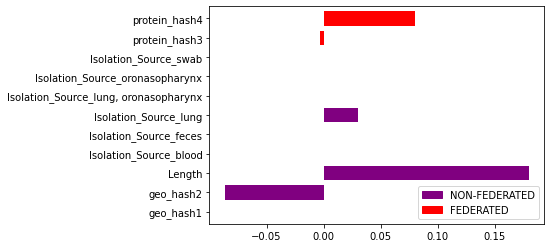

In [238]:
# shap
phi = fs.kernel_shap(f_knn, x, med, M)
base_value = phi[-1]
shap_values = phi[:-1]
shap_values_df = pd.DataFrame(data = np.array([shap_values]), columns = list(X_train))
print("Shap Values")
#shap_values_df
row = shap_values_df.iloc[0]

ax=row.plot(kind='barh', color=['purple','purple','purple','purple','purple','purple',
                             'purple','purple','purple','red','red'], width=0.75, legend=True)


import matplotlib.patches as mpatches
fd = mpatches.Patch(color='purple', label='NON-FEDERATED')
nfd = mpatches.Patch(color='red', label='FEDERATED')
ax.legend(handles=[fd,nfd], loc=4)

In [239]:
##########################################
shap.initjs()
f = lambda x: knn.predict_proba(x)[:,1]
med = X_train.median().values.reshape((1,X_train.shape[1]))
explainer = shap.KernelExplainer(f, med)
shap_values_single = explainer.shap_values(X.iloc[0,:], nsamples=1000)
shap.force_plot(explainer.expected_value, shap_values_single, shap_values_df.iloc[0,:])
##########################################

(168,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Accuracy : 96.43 %


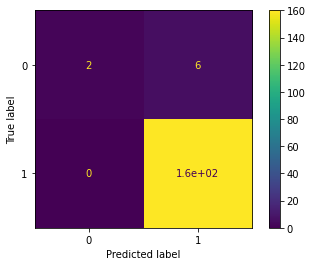

In [240]:
print(y_test.shape)
model = lambda x: knn_norm.predict_proba(x)[:,1]
y_pred=knn.predict(X_test)

print(y_pred)

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

acr3=accuracy_score(y_test,y_pred)*100
print("Accuracy : {:.2f}".format(acr3),"%")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=knn.classes_)
disp.plot()
plt.show()

In [228]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
con=confusion_matrix(y_test, y_pred)

============================================

[  0.  -3. 121.   0.   0.   1.   0.   0.   0.   1.  -2.]
Federated Shap Values


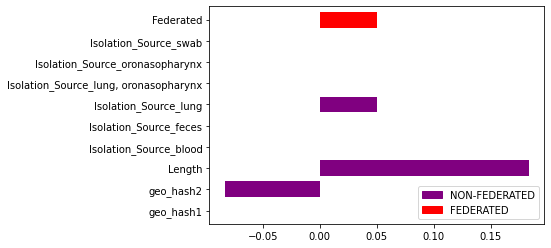

In [246]:
# federated shap
fed_pos = 9
print(x)
phi = fs.kernel_shap_federated(f_knn, x, med, M, fed_pos)
base_value = phi[-1]
shap_values = phi[:-1]
new_columns = list(X_train)[:fed_pos]
new_columns.extend(['Federated'])
shap_values_df = pd.DataFrame(data = np.array([shap_values]), columns = new_columns)
print("Federated Shap Values")
#shap_values_df.plot()
row = shap_values_df.iloc[0]
ax=row.plot(kind='barh', color=['purple','purple','purple','purple','purple','purple','purple','purple','purple','red'], width=0.75, legend=True)

import matplotlib.patches as mpatches
fd = mpatches.Patch(color='purple', label='NON-FEDERATED')
nfd = mpatches.Patch(color='red', label='FEDERATED')
ax.legend(handles=[fd,nfd], loc=4)

In [247]:
#Aggregated and average shap
shap_values_whole = []
counttt = 0
for index, row in X_train.iterrows():
    counttt += 1
    if counttt > 50:
        break
    x = row
    phi = fs.kernel_shap(f_knn, x, med, M)
    base_value = phi[-1]
    shap_values = phi[:-1]
    shap_values_whole.append(list(shap_values))
shap_values_whole = np.array(shap_values_whole)
print(shap_values_whole)

    

[[ 5.50935511e-08 -8.66666116e-02  1.80000055e-01  5.50899131e-08
   5.50871846e-08  3.00000551e-02  5.50917321e-08  5.50899131e-08
   5.50935511e-08 -3.33327824e-03  8.00000551e-02]
 [ 9.09494702e-13 -2.72848411e-12  2.00000000e-01 -2.72848411e-12
  -2.72848411e-12 -3.63797881e-12  3.63797881e-12  0.00000000e+00
   4.54747351e-12  1.81898940e-12  3.63797881e-12]
 [ 0.00000000e+00 -6.66666667e-02  1.66666667e-01  0.00000000e+00
  -5.45696821e-12  1.00000000e-01  3.63797881e-12  3.63797881e-12
   1.81898940e-12  4.54747351e-12  9.09494702e-13]
 [ 3.63797881e-12 -8.33333333e-02  1.83333333e-01 -5.45696821e-12
  -1.81898940e-12  8.33333333e-02  2.72848411e-12 -9.09494702e-13
   2.72848411e-12  1.81898940e-12  1.66666667e-02]
 [ 0.00000000e+00 -1.00000000e-01  2.00000000e-01 -1.81898940e-12
  -4.54747351e-12  1.00000000e-01  1.81898940e-12  1.81898940e-12
   2.72848411e-12  3.63797881e-12  1.81898940e-12]
 [ 2.75455022e-07 -8.33330579e-02  1.83333609e-01  2.75450475e-07
   2.75452294e-07  

In [156]:
#Aggregated and average federated shap
shap_values_whole = []
cols_federated_7 = ['Length', 'C', 'D', 'E', 'F', 'Isolation_Source_blood',
       'Isolation_Source_feces']
cols_federated_5 = ['Length','Isolation_Source_blood','Isolation_Source_lung','Isolation_Source_lung, oronasopharynx']
counttt = 0
M = 11
fed_pos = 6
for index, row in X_train.iterrows():
    counttt += 1
    if counttt > 1000:
        break
    x = np.array(row)
    #print('x',x)
    #print('M',M)
    #print('fed_pos',fed_pos)
    #print(med)
    phi = fs.kernel_shap_federated(f_knn, x, med, M, fed_pos)
    base_value = phi[-1]
    shap_values = phi[:-1]
    shap_values_whole.append(list(shap_values))
shap_values_whole = np.array(shap_values_whole)
#print(shap_values_whole)

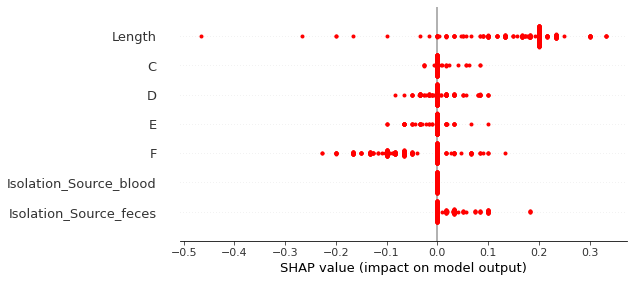

In [157]:
shap.summary_plot(shap_values_whole, feature_names = cols_federated_7 ,sort=False, color = 'r')

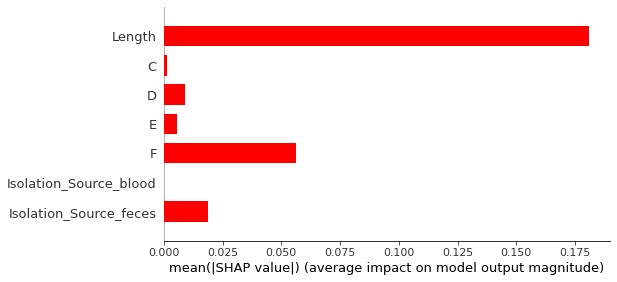

In [158]:
shap.summary_plot(shap_values_whole, feature_names = cols_federated_7 ,sort=False,  plot_type="bar", color = 'r')

In [159]:
X_train.loc[250]

Length                                   75.0
protein_hash3                            -2.0
protein_hash4                             4.0
geo_hash1                                 0.0
geo_hash2                                -3.0
Isolation_Source_blood                    0.0
Isolation_Source_feces                    0.0
Isolation_Source_lung                     1.0
Isolation_Source_lung, oronasopharynx     0.0
Isolation_Source_oronasopharynx           0.0
Isolation_Source_swab                     0.0
Name: 250, dtype: float64